Shape optimization
==================

## Overview 

In this tutorial, we will optimize a triangle mesh to match a target shape specfied using a set of reference renderings.

Gradients with regards to vertex positions are typically extremely sparse, since only vertices located on visibility discontinuities receive a contribution. As a consequence, naively optimizing a triangle mesh generally results in horrible, tangled meshes.

To avoid this, we will use the method from the paper "[Large Steps in Inverse Rendering of Geometry][1]". This method optimizes a latent variable that enables smoother gradients.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**
    
<ul>
  <li>Create a sensor that batches several viewpoints together</li>
  <li>Use the "large steps" algorithm to optimize a shape</li>
  <li>Use remeshing to refine the optimized shape</li>
</ul>
    
</div>

[1]: http://rgl.epfl.ch/publications/Nicolet2021Large

## Setup

As always, let's import `drjit` and `mitsuba` and set a differentiation-aware variant.

In [1]:
import sys
sys.path.insert(0, '/home/bnicolet/Documents/code/mitsuba3/build/python')
import mitsuba as mi
mi.set_variant("cuda_ad_rgb")
import drjit as dr
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt

from ipywidgets import interact

%load_ext autoreload
%autoreload 2

Using this method will require `cholespy`, a package to solve sparse linear systems with Cholesy factorisations.

In [ ]:
!pip install cholespy

## Batched rendering

In order to accurately recover a shape, we need several reference renderings, taken from different viewpoints. Rather than rendering each viewpoint separately during the optimisation like in the [volume optimisation tutorial](https://mitsuba.readthedocs.io/en/stable/src/inverse_rendering/volume_optimization.html#Optimization), we will use the `batch` sensor, that allows us to render all views at once. This allows us to avoid the cost of JIT tracing for each viewpoint. When optimizing visibility-related quantities, we have to set the `sample_border` flag to `True`. This enables keeping track of objects that may leave the frame.

In [3]:
sensor_count = 8
sensor = {
    'type': 'batch',
    'film': {
        'type': 'hdrfilm',
        'width': 256*sensor_count, 'height': 256,
        'filter': {'type': 'gaussian'},
        'sample_border': True
    }
}

The batch sensor expects a list of nested sensors. Here we will generate 8 viewpoints evenly distributed on the sphere, using the [Fibonacci lattice](http://extremelearning.com.au/evenly-distributing-points-on-a-sphere/).

In [4]:
from mitsuba import ScalarTransform4f as T

golden_ratio = (1 + 5**0.5)/2
for i in range(sensor_count):
    # theta = 2*np.pi / sensor_count * i
    theta = 2*np.pi * i / golden_ratio
    phi = np.arccos(1 - 2*(i+0.5)/sensor_count)
    d = 5
    origin = [d*np.cos(theta) * np.sin(phi), d*np.sin(theta) * np.sin(phi), d*np.cos(phi)]
    sensor[f"sensor_{i}"] = {
        'type': 'perspective',
        'fov': 45,
        # 'to_world': T.look_at(target=[0, 0, 0], origin=[5*np.cos(theta), 2, 5*np.sin(theta)], up=[0, 1, 0])
        'to_world': T.look_at(target=[0, 0, 0], origin=origin, up=[0, 1, 0])
    }

## Scene construction

Let's now generate the reference renderings. We will load a scene with the previous sensor, the target mesh, and an environment map. Note the use of the `direct_reparam` integrator, that properly accounts for visibility discontinuities when differentiating.

In [5]:
scene_dict = {
    'type': 'scene',
    'integrator': {
        'type': 'direct_reparam',
    },
    'sensor': sensor,
    'emitter': {
        'type': 'envmap',
        'filename': "../scenes/textures/envmap2.hdr",
    },
    'shape': {
        'type': 'ply',
        'filename': "../scenes/meshes/suzanne.ply",
        # 'to_world': T.scale(18),
        'bsdf': {'type': 'diffuse'}
    }
}

scene_target = mi.load_dict(scene_dict)

We can now generate the reference renderings.

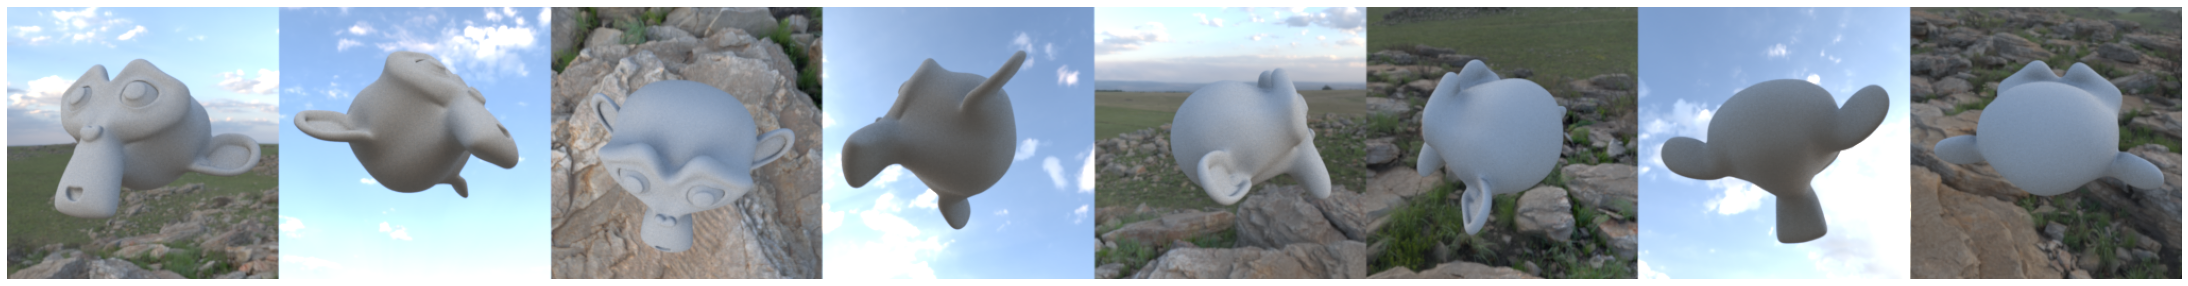

In [6]:
ref_img = mi.render(scene_target, spp=256)

fig, ax = plt.subplots(figsize=(5*sensor_count, 5))
ax.imshow(mi.util.convert_to_bitmap(ref_img))
ax.axis('off');

Now let's create the scene we will optimise. We will use a dense sphere as a starting point.

In [7]:
scene_dict['shape']['filename'] = '../scenes/meshes/ico_10k.ply'
scene_source = mi.load_dict(scene_dict)

We can visualize the initial state.

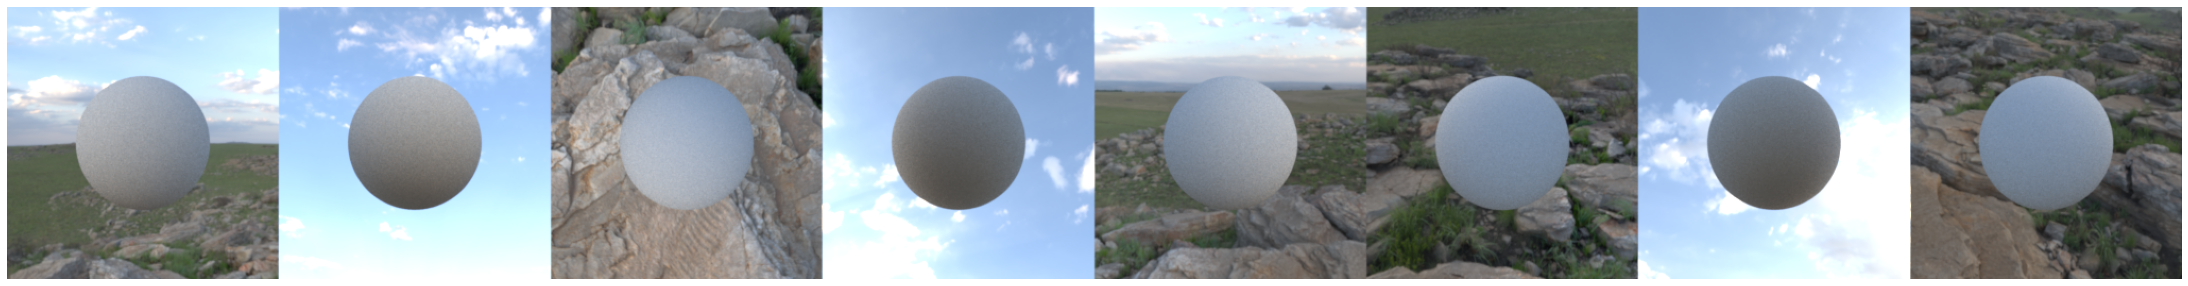

In [8]:
init_img = mi.render(scene_source, spp=128)

fig, ax = plt.subplots(figsize=(5*sensor_count, 5))
ax.imshow(mi.util.convert_to_bitmap(init_img))
ax.axis('off');

## Naive optimization

It would be tempting to apply the same steps as in previous tutorials, i.e. simply render the scene, compute a loss, and differentiate. Let's try that first.

In [9]:
params = mi.traverse(scene_source)
opt = mi.ad.Adam(lr=1e-1)
opt['shape.vertex_positions'] = params['shape.vertex_positions']

In [10]:
for it in range(5):
    loss = mi.Float(0.0)

    params.update(opt)

    img = mi.render(scene_source, params, seed=it, spp=64)

    # L1 Loss
    loss = dr.mean(dr.abs(img - ref_img))
    dr.backward(loss)
    opt.step()

    print(f"Iteration {1+it:03d}: Loss = {loss[0]:6f}", end='\r')


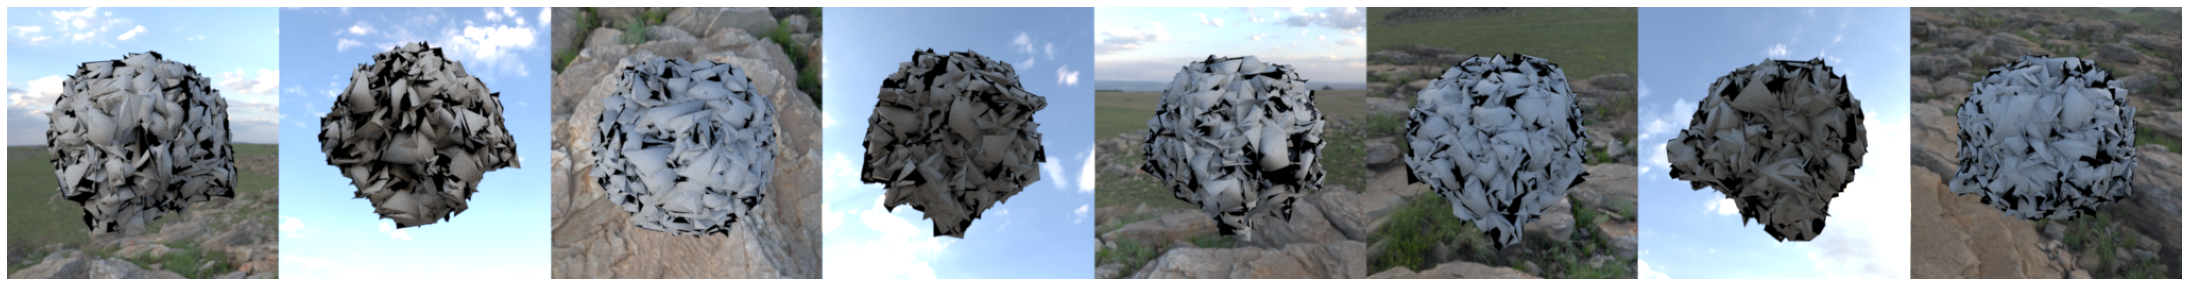

In [11]:
final_img = mi.render(scene_source, spp=128)
fig, ax = plt.subplots(figsize=(5*sensor_count, 5))
ax.imshow(mi.util.convert_to_bitmap(final_img))
ax.axis('off');

As you can see, after only a few steps, this produces an unusable mess of triangles. This is a consequence of the sparsity of the visibility-related gradients. Indeed, those are only present on edges that are on the silouhette of the mesh for a given viewpoint. We will now see a method to remedy this.

## Large Steps Optimization

Rather than directly optimizing cartesian vertex coordinates, the paper "Large Steps in Inverse Rendering of Geometry" [Nicolet et al. 2021] introduces a latent representation that allows to obtain smoother gradients. This approach is available in Mitsuba 3 in the `mi.ad.LargeSteps` class.

The latent variable is defined as u = (I + λL) v, where v denotes the vertex positions, is the (combinatorial) Laplacian of the given mesh, and λ is a user-defined hyper-parameter. Intuitively, this parameter defines how much the gradients should be smoothed on the surface.

Let's start by resetting the scene.

In [12]:
scene_source = mi.load_dict(scene_dict)
params = mi.traverse(scene_source)

We can now instantiate the `LargeSteps` class for out mesh. 

If the mesh has duplicate vertices (e.g. due to face normals or UV seams), it will internally convert the mesh to a unique representation to avoid unwanted behavior during the optimisation.

In [13]:
lambda_ = 25
ls = mi.ad.LargeSteps(params['shape.vertex_positions'], params['shape.faces'], lambda_)

This also requires using a modification of the _Adam_ optimizer, that uses a uniform second moment for all parameters. This can be enabled by setting `uniform=True` when instantiating the optimizer.

In [14]:
opt = mi.ad.Adam(lr=1e-1, uniform=True)

The `LargeSteps` class allows to convert back and forth between cartesian and differential representation of the vertex coordinates. We use `LargeSteps.to_differential` to initialize the latent variable.

In [15]:
opt['u'] = ls.to_differential(params['shape.vertex_positions'])

We can now run the optimisation. Compared to our earlier attempt, the only additional step is to convert the latent variable to cartesian coordinates, using `LargeSteps.from_differential`

In [16]:
for it in range(100):
    loss = mi.Float(0.0)

    # Retrieve the vertex positions from the latent variable
    params['shape.vertex_positions'] = ls.from_differential(opt['u'])
    params.update()

    img = mi.render(scene_source, params, seed=it, spp=64)

    # L1 Loss
    loss = dr.mean(dr.abs(img - ref_img))
    dr.backward(loss)
    opt.step()

    print(f"Iteration {1+it:03d}: Loss = {loss[0]:6f}", end='\r')

## Intermediate result

The optimization state can be obtained from the latent variable:

In [17]:
params['shape.vertex_positions'] = ls.from_differential(opt['u'])
params.update();

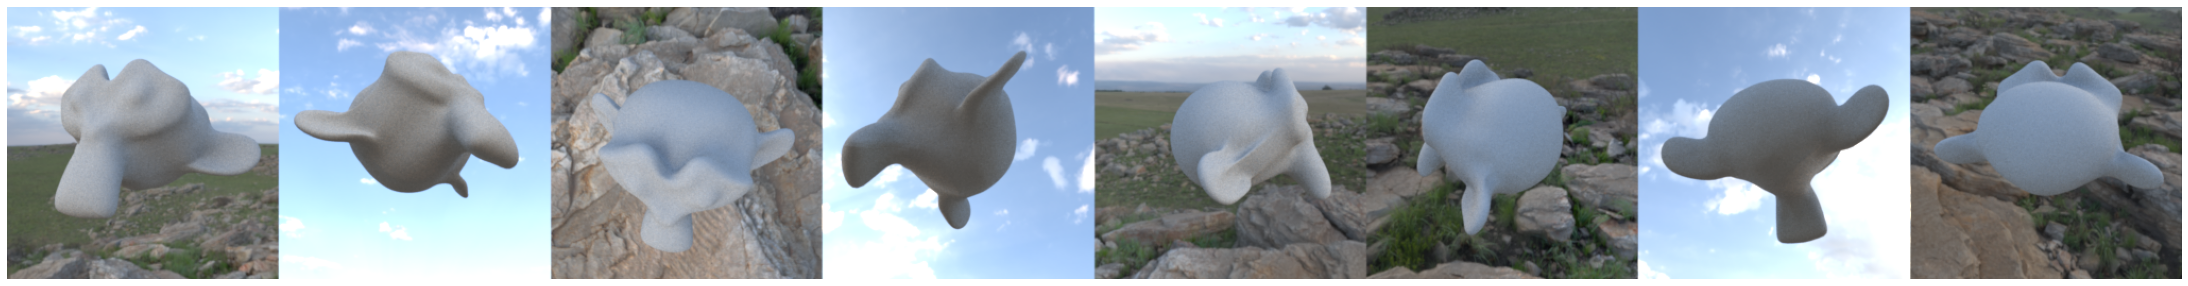

In [18]:
final_img = mi.render(scene_source, spp=128)
fig, ax = plt.subplots(figsize=(5*sensor_count, 5))
ax.imshow(mi.util.convert_to_bitmap(final_img))
ax.axis('off');

## Remeshing

The result above can be further improved with the help of remeshing. By increasing the tesselation of the mesh, we will be able to recover more details of the target shape. 

We will use the Botsch-Kobbelt remeshing algorithm provided by the `gpytoolbox` package:

In [ ]:
!pip install gpytoolbox

Since the `gpytoolbox` package expects NumPy arrays, we will first convert the mesh data to the correct format.

In [20]:
v_np = params['shape.vertex_positions'].numpy().reshape((-1,3)).astype(np.float64)
f_np = params['shape.faces'].numpy().reshape((-1,3))

The Botsch-Kobbelt remeshing algorithm takes a "target edge length" as input argument. This controls the desired tesselation of the mesh. Since we want to increase resolution, we will set this as half of the mean edge length of the current mesh.

In [21]:
# Compute average edge length
l0 = np.linalg.norm(v_np[f_np[:,0]] - v_np[f_np[:,1]], axis=1)
l1 = np.linalg.norm(v_np[f_np[:,1]] - v_np[f_np[:,2]], axis=1)
l2 = np.linalg.norm(v_np[f_np[:,2]] - v_np[f_np[:,0]], axis=1)

target_l = np.mean([l0, l1, l2]) / 2

We can now run the Botsch-Kobbelt remeshing algorithm. It runs for a user-specified number of iterations, which we set to 5 here. For more detail on that algorithm, see the [documentation](https://gpytoolbox.org/0.1.0/remesh_botsch/)

In [22]:
from gpytoolbox import remesh_botsch

v_new, f_new = remesh_botsch(v_np, f_np, i=5, h=target_l, project=True)

We can now update the vertex and face buffers of the mesh with the new ones.

If your mesh has other attributes (e.g. UV coordinates), you will also need to update them. By default, Mitsuba will reset those to 0 if the vertex or face count is altered, while those are unchanged.

In [23]:
params['shape.vertex_positions'] = mi.Float(v_new.flatten().astype(np.float32))
params['shape.faces'] = mi.Int(f_new.flatten())
params.update();

Since the mesh topology has changed, we need to compute a new latent variable:

In [24]:
ls = mi.ad.LargeSteps(params['shape.vertex_positions'], params['shape.faces'], lambda_)
opt = mi.ad.Adam(lr=1e-1, uniform=True)
opt['u'] = ls.to_differential(params['shape.vertex_positions'])

We can now continue the optimisation

In [25]:
for it in range(150):
    loss = mi.Float(0.0)

    # Retrieve the vertex positions from the latent variable
    params['shape.vertex_positions'] = ls.from_differential(opt['u'])
    params.update()

    img = mi.render(scene_source, params, seed=it, spp=64)

    # L1 Loss
    loss = dr.mean(dr.abs(img - ref_img))
    dr.backward(loss)
    opt.step()

    print(f"Iteration {1+it:03d}: Loss = {loss[0]:6f}", end='\r')


## Final result

We recover the final state from the latent variable:

In [26]:
params['shape.vertex_positions'] = ls.from_differential(opt['u'])
params.update();

We can now compare our end result (bottom) to our reference views (top)

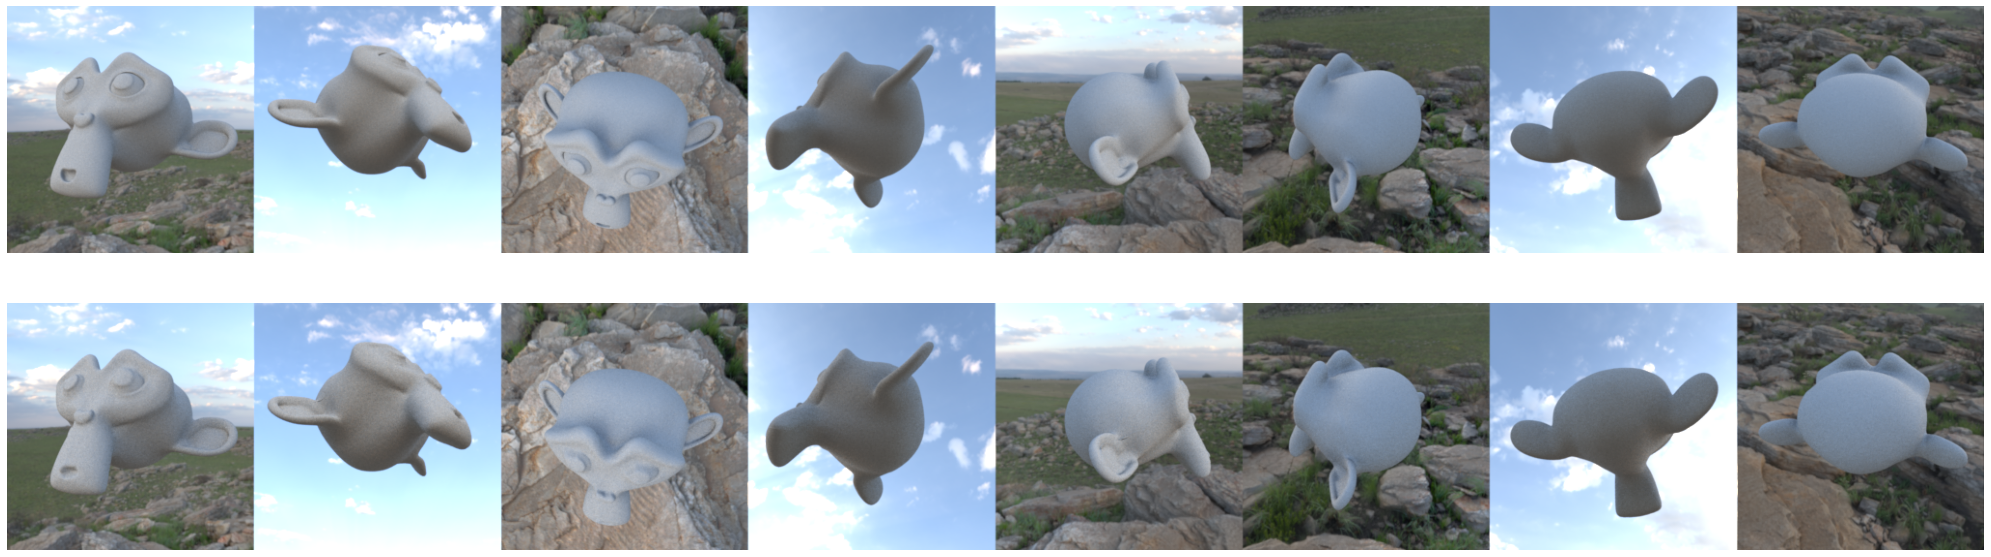

In [27]:
final_img = mi.render(scene_source, spp=128)

fig, ax = plt.subplots(nrows=2, figsize=(5*sensor_count, 10))
for i, img in enumerate((ref_img, final_img)):
    ax[i].imshow(mi.util.convert_to_bitmap(img))
    ax[i].axis('off')

Note that the results could be further improved by e.g. using more input views, or using a less agressive step size and more steps.

## See also

- [<code>mitsuba.ad.integrators.direct_reparam</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.direct_reparam)
- [<code>batch</code> plugin](https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_sensors.html#batch-sensor-batch)